<a href="https://colab.research.google.com/github/Biline-dev/IARN/blob/main/TP_6_RN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

présenté par 

 * Boulmaali Linda Imene 181832040766

# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1DAFe-ihG-uA6Hk141ynRu_ao08bfS1Yu'}) # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv') 
downloaded = drive.CreateFile({'id':'1-C_AobQc_FLJDFbnp1HNerFEK9ozAUqM'}) # replace the id with id of file you want to access
downloaded.GetContentFile('W1.csv') 
downloaded = drive.CreateFile({'id':'180wPq3eybmRJ6IlMDNrSC8qoAXwinT-v'}) # replace the id with id of file you want to access
downloaded.GetContentFile('W2.csv') 

# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
m, n=data.shape

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

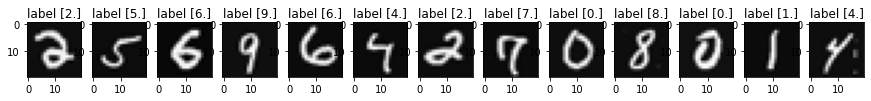

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [ ]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [ ]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [ ]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [ ]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [ ]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [ ]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    
    reg_=(1/ (2 * X.shape[0])) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3))))) + lambda_*reg_;

    return J



# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [ ]:
def SigmoidGradient(z):
    return Sigmoid(z)*(1-Sigmoid(z));

In [ ]:
def NNCostFunction(X, YY, theta1, theta2, hidden_layer_size, lambda_):

    a1=X # (5000,401)
    z2 = np.dot(a1, theta1.T) # (5000, 25)
    a2 = Sigmoid(z2) # (5000, 25)
    
    # Add 1's for the bias unit.
    a2 = np.insert(a2, 0, 1, axis=1) # (5000,26)
    z3 = np.dot(a2, theta2.T) # (5000, 10)
    a3 = Sigmoid(z3) # (5000, 10)
   
    # Initialize Delta matrices.
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1)) # (25,401)
    D2 = np.zeros((num_labels, hidden_layer_size + 1)) # (10,26)

    # for each training example
    for t in range(m):

        # Compute the error delta.
        d_3 = a3[t] - YY[t] # (10,)
        d_3 = d_3.reshape(-1,1) # (10,1)
        d_2 = np.dot(theta2.T[1:,:], d_3) * \
                     SigmoidGradient(z2[t].reshape(-1,1))
        D1 += np.dot(d_2, a1[t].reshape(-1, 1).T) # (25,401)
        D2 += np.dot(d_3, a2[t].reshape(1,-1)) # (10,26)


    D1 = D1 / m
    D2 = D2 / m
    D1[:,1:] = D1[:,1:] + (lambda_/ m) * theta1[:,1:]
    D2[:,1:] = D2[:,1:] + (lambda_/ m) * theta2[:,1:]
    
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_)

    return J, [D1, D2]

In [ ]:
def randInitializeWeights():
  # Set the range epsilon.
  epsilon_init = 0.12
  theta = [np.random.rand(hidden_layer_size, 1 + input_layer_size ) * (2 * epsilon_init) - epsilon_init, \
           np.random.rand(num_labels, 1 + hidden_layer_size) * (2 * epsilon_init) - epsilon_init]
  return theta 

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [ ]:
def gradientDescent(X, y, theta, alpha, iterations, lambda_ = 0):
    costs_history = [] 

    for _ in range(iterations):

        J, grad = NNCostFunction(X, y, theta[0], theta[1], hidden_layer_size, lambda_)
        
        theta[0] = theta[0] - alpha * grad[0]
        theta[1] = theta[1] - alpha * grad[1]
        
        costs_history.append(J)
        
    return theta, np.asarray(costs_history)

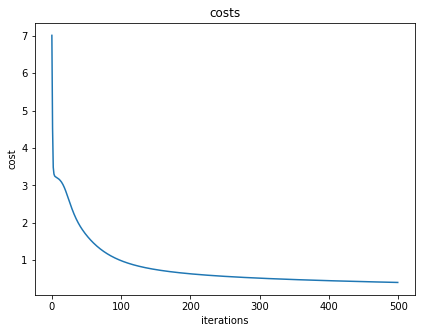

In [ ]:
iterations = 500
alpha = 1.5
theta = randInitializeWeights()
lambda_=0

theta, costs= gradientDescent(X, YY, theta, alpha, iterations, lambda_)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("costs")
plt.plot(range(costs.shape[0]), costs)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [ ]:
computeCost(X, YY, theta[0], theta[1], hidden_layer_size, 0)

0.40053489869459535

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

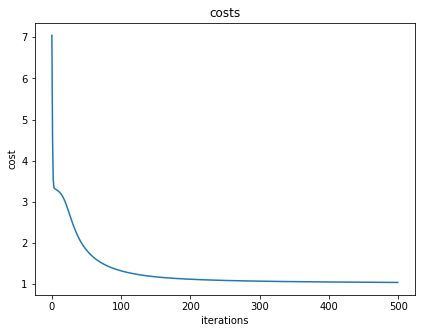

In [ ]:
iterations = 500
alpha = 1.5
lambda_=10
theta = randInitializeWeights()
theta_reg, costs= gradientDescent(X, YY, theta, alpha, iterations,lambda_)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("costs")
plt.plot(range(costs.shape[0]), costs)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [ ]:
computeCost(X, YY, theta_reg[0], theta_reg[1], hidden_layer_size, 0)

0.6248252545636995

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    layer1= Sigmoid(np.dot(X, W1.T))
    X0=np.ones((1,X.shape[0]))
    layer2 = np.insert(layer1,0, X0, axis=1) 
    layer2 = Sigmoid(np.dot(layer2 , W2.T))
    y_pred = np.argmax(layer2, axis=1)


    return y_pred

In [ ]:
#la précision du modele

y_pred = predict (theta[0], theta[1], X)
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision

93.08

In [ ]:
# la précision du modele avec régularisation

y_pred = predict (theta_reg[0], theta_reg[1], X)
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision

93.08

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    max_iter=5000,
                    hidden_layer_sizes=(25,), 
                    random_state=1)

clf.fit(X[:, 1:], YY)   

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(25,), max_iter=5000,
              random_state=1, solver='lbfgs')

In [ ]:
y_pred = np.argmax(clf.predict(X[:, 1:]), axis=1)
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y[i]:
    p+=1
precision = p*100/5000
precision

100.0

In [ ]:
clf.score(X[:, 1:], YY)*100

100.0

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

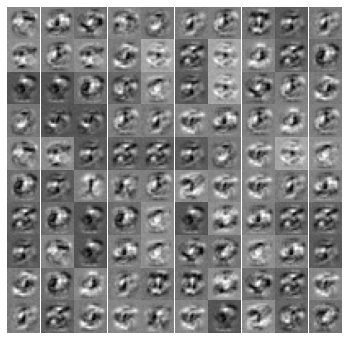

In [ ]:
def displayData(X):

    fig, axarr = plt.subplots(10, 10,
                             figsize=(6, 6),
                             gridspec_kw={'wspace':0,
                                          'hspace':0})
    for i in range(10):
        for j in range(10):
            # Select random indices.
            idx = np.random.choice(len(X), 1)
            # Index the array X with the indices.
            pixels = X[idx, 1:] # shape(1, 400)
            pixels = pixels.reshape(-1, 20) # shape(20, 20)
            axarr[i,j].imshow(pixels.T, cmap='gray_r')
            # Remove ticks.
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            # Turn off axes.
            axarr[i,j].axis('off')
    plt.show()

displayData(theta[0])

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance